# Set Environment

In [ ]:
import collections
import cv2
import glob
import joblib
import keras_tuner as kt
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import warnings
import zipfile

from concurrent.futures import ThreadPoolExecutor
from config import METADATA_DIR, IMAGES_DIR, ARRAYS_DIR, FEATURES_DIR, MODELS_DIR, EXPERIMENTS_DIR
from joblib import Parallel, delayed
from PIL import Image
from posixpath import split
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import graycomatrix, graycoprops, hog
from skimage.filters import sobel
from skimage.io import imread
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

warnings.filterwarnings("ignore")

**Read in metadata**

In [5]:
train_meta = pd.read_parquet(METADATA_DIR / "train_metadata.parquet")
test_meta = pd.read_parquet(METADATA_DIR / "test_metadata.parquet")
val_meta = pd.read_parquet(METADATA_DIR / "validation_metadata.parquet")

# Read in resized arrays
- sized to shape (224, 224, 3) and saved to disk

In [6]:
# Read arrays back
train_file_path = sorted(glob.glob(str(ARRAYS_DIR / "train" / "image_*.npy")))
val_file_path = sorted(glob.glob(str(ARRAYS_DIR / "validation" / "image_*.npy")))
test_file_path = sorted(glob.glob(str(ARRAYS_DIR / "test" / "image_*.npy")))

def load_npy(file_path):
  return np.load(file_path)

with ThreadPoolExecutor(max_workers=6) as executor:
  train_arrays = list(executor.map(load_npy, train_file_path))
  val_arrays = list(executor.map(load_npy, val_file_path))
  test_arrays = list(executor.map(load_npy, test_file_path))

In [11]:
file_paths = sorted(glob.glob(str(ARRAYS_DIR / "train" / "image_*.npy")))
arrays = [np.load(fp) for fp in file_paths]

# HOG/GLCM Feature Extraction

In [12]:
def hog_extraction(image_array):
  hog_extract = hog(
      image_array,
      orientations=9,
      pixels_per_cell=(8,8),
      cells_per_block=(2,2),
      block_norm='L2-Hys',
      visualize=False,
      feature_vector=False,
      channel_axis=2
  )

  return np.mean(hog_extract, axis=(0,1))

hog_features = Parallel(n_jobs=-1)(
    delayed(hog_extraction)(array) for array in arrays
)

hog_list = [feature.ravel() for feature in hog_features]

hog_df = pd.DataFrame(hog_list, columns = [f"hog_{i}" for i in range(36)])

In [34]:
def glcm(image_array):
    array = rgb2gray(image_array)
    gray_array = np.floor(array * 15).astype(np.uint8)
    my_matrix = graycomatrix(
        gray_array,
        distances=[1, 2],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi / 4],
        levels=16,
        symmetric=True,
        normed=True
    )

    contrast_array = np.mean(graycoprops(my_matrix, 'contrast'), axis=1)
    homogeneity_array = np.mean(graycoprops(my_matrix, 'homogeneity'), axis=1)
    energy_array = np.mean(graycoprops(my_matrix, 'energy'), axis=1)
    correlation_array = np.mean(graycoprops(my_matrix, 'correlation'), axis=1)
    entropy_array = np.mean(graycoprops(my_matrix, 'entropy'), axis=1)

    return {
        'contrast_d1': contrast_array[0],
        'contrast_d2': contrast_array[1],
        'homogeneity_d1': homogeneity_array[0],
        'homogeneity_d2': homogeneity_array[1],
        'energy_d1': energy_array[0],
        'energy_d2': energy_array[1],
        'correlation_d1': correlation_array[0],
        'correlation_d2': correlation_array[1],
        'entropy_d1': entropy_array[0],
        'entropy_d2': entropy_array[1],
    }

glcm_df = pd.DataFrame(Parallel(n_jobs=-1)(
    delayed(glcm)(array) for array in arrays
))

# Image transformations

## Example transformations

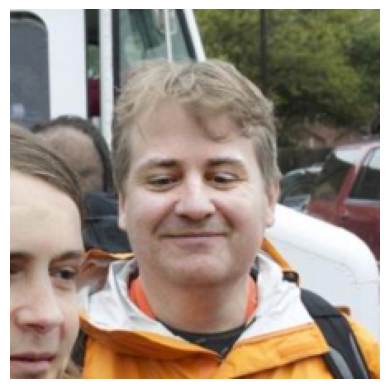

In [30]:
# Original

my_array = arrays[1442]
plt.imshow(my_array)
plt.axis('off')
plt.show()

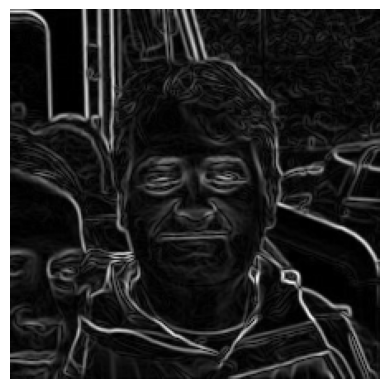

In [31]:
# plot the edges

edges = sobel(my_array.mean(axis=2))

plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

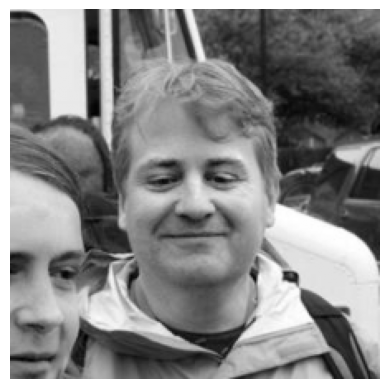

In [32]:
# Gray scale

gray = rgb2gray(my_array)

plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

## Exploratory Data Analysis

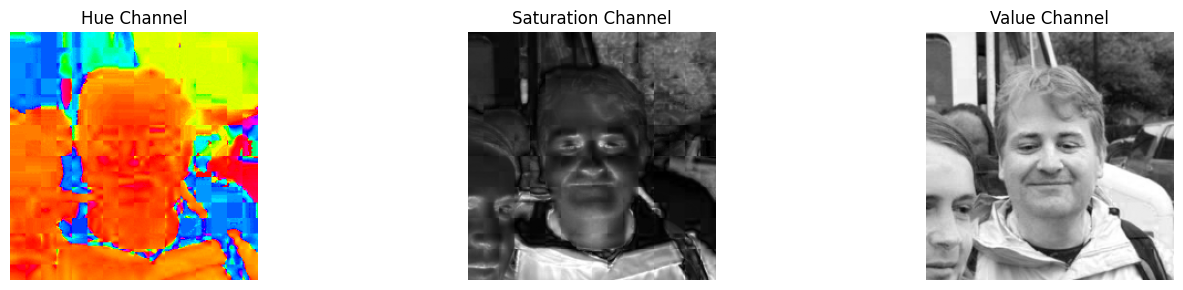

In [33]:
# Hue, saturation and value

hsv = rgb2hsv(my_array)

# Hue shows us the main color of the pixel (think about how red has the same hue but brightness and intensity can give us dark or bright red)
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(hsv[...,0], cmap='hsv')
plt.title('Hue Channel')
plt.axis('off')

# Saturation shows us the intensity of the colors (white is vivid and black is dull)
plt.subplot(1,3,2)
plt.imshow(hsv[...,1], cmap='gray')
plt.title('Saturation Channel')
plt.axis('off')


# Value is how bright the colors are.  Useful for detecting edges and shadows
plt.subplot(1,3,3)
plt.imshow(hsv[...,2], cmap='gray')
plt.title('Value Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
train_histograms = pd.read_parquet(FEATURES_DIR / "color_histogram" / "train_histogram.parquet")

**Single image frequency plot**

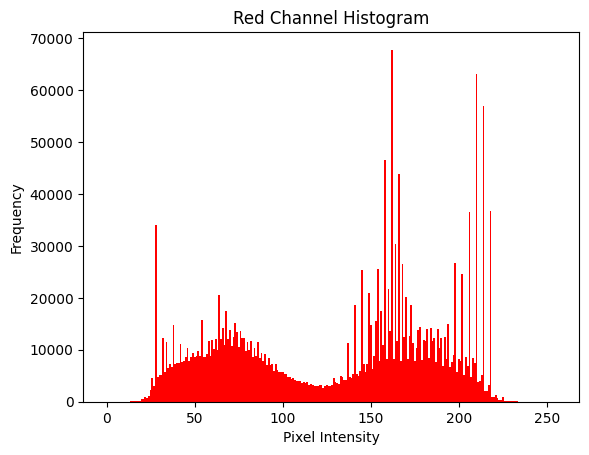

In [39]:
red = train_histograms.loc[0, 'r_0':'r_255']
pixel_intensity = np.arange(256)

plt.bar(pixel_intensity, red, width=1.0, color='red')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Red Channel Histogram')
plt.show()

**Frequency plot across dataset**

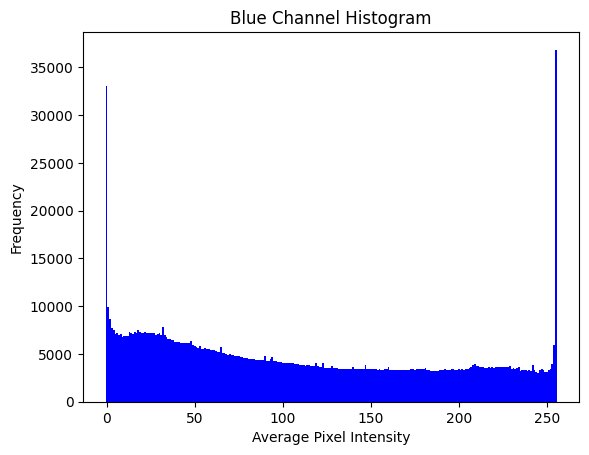

In [40]:
average_blue = np.array(train_histograms.loc[:, 'b_0':'b_255'].mean(axis=0))
pixel_intensity = np.arange(256)

plt.bar(pixel_intensity, average_blue, width=1.0, color='blue')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Blue Channel Histogram')
plt.show()

**Density Plot**

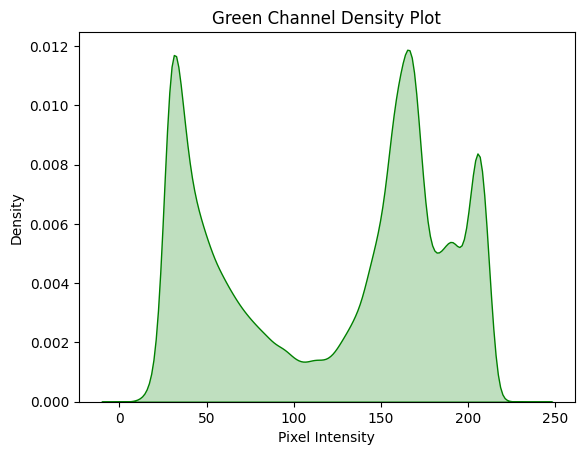

In [41]:
green = train_histograms.loc[0, 'g_0':'g_255']
pixel_intensity = np.arange(256)

# Simulate the raw count of pixel data to estimate density properly
simulated_pixels = np.repeat(np.arange(256), green.astype(int))

sns.kdeplot(simulated_pixels, color='green', fill=True)
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.title("Green Channel Density Plot")
plt.show()

**Brightness/Mean**

**AI vs Human Exploration**

In [42]:
# Split the train/test/validation sets into AI and human sets

train_temp = pd.DataFrame({
    'label': train_meta['label'].values,
    'image': list(train_arrays)
})

train_split_class0 = train_temp[train_temp['label'] == 0].copy()
train_split_class1 = train_temp[train_temp['label'] == 1].copy()

test_temp = pd.DataFrame({
    'label': test_meta['label'].values,
    'image': list(test_arrays)
})

test_split_class0 = test_temp[test_temp['label'] == 0].copy()
test_split_class1 = test_temp[test_temp['label'] == 1].copy()

val_temp = pd.DataFrame({
    'label': val_meta['label'].values,
    'image': list(val_arrays)
})

val_split_class0 = val_temp[val_temp['label'] == 0].copy()
val_split_class1 = val_temp[val_temp['label'] == 1].copy()

**RGB value variation**

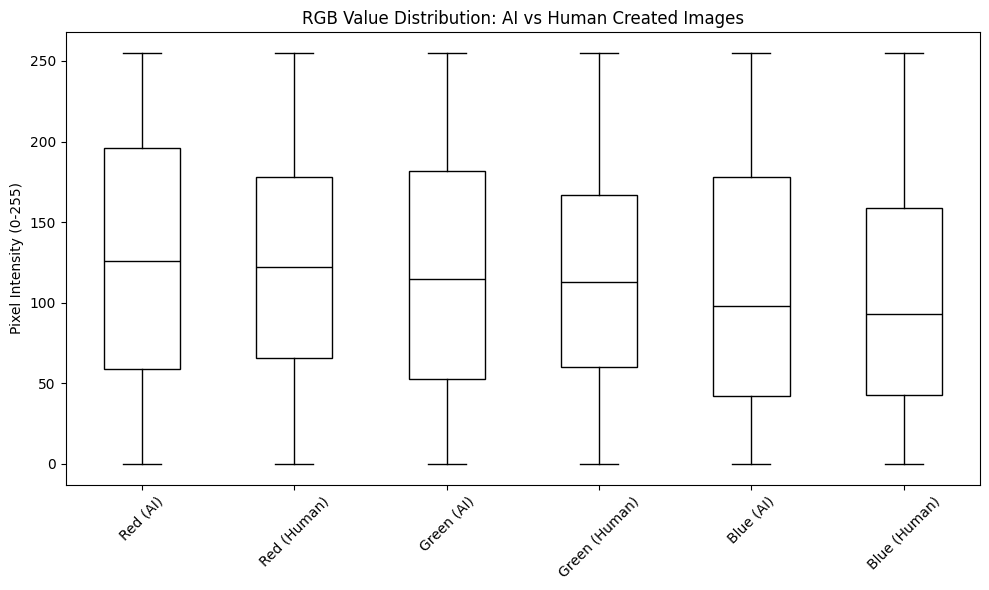

In [43]:
train_class0_array = np.array(train_split_class0['image'].tolist())
train_class1_array = np.array(train_split_class1['image'].tolist())

# --- AI Generated ---
train_class0_array = np.array(train_split_class0['image'].tolist())
stacked0 = np.stack(train_class0_array, axis=0)
R_ai = stacked0[:, :, :, 0].flatten()
G_ai = stacked0[:, :, :, 1].flatten()
B_ai = stacked0[:, :, :, 2].flatten()

# --- Human Created ---
train_class1_array = np.array(train_split_class1['image'].tolist())
stacked1 = np.stack(train_class1_array, axis=0)
R_human = stacked1[:, :, :, 0].flatten()
G_human = stacked1[:, :, :, 1].flatten()
B_human = stacked1[:, :, :, 2].flatten()

# Combine into one plot
data = [
    R_ai, R_human,
    G_ai, G_human,
    B_ai, B_human
]

labels = [
    'Red (AI)', 'Red (Human)',
    'Green (AI)', 'Green (Human)',
    'Blue (AI)', 'Blue (Human)'
]

plt.figure(figsize=(10, 6))
plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor='white', color='black'),
    medianprops=dict(color='black')
)
plt.ylabel('Pixel Intensity (0-255)')
plt.title('RGB Value Distribution: AI vs Human Created Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Brightness/Mean**

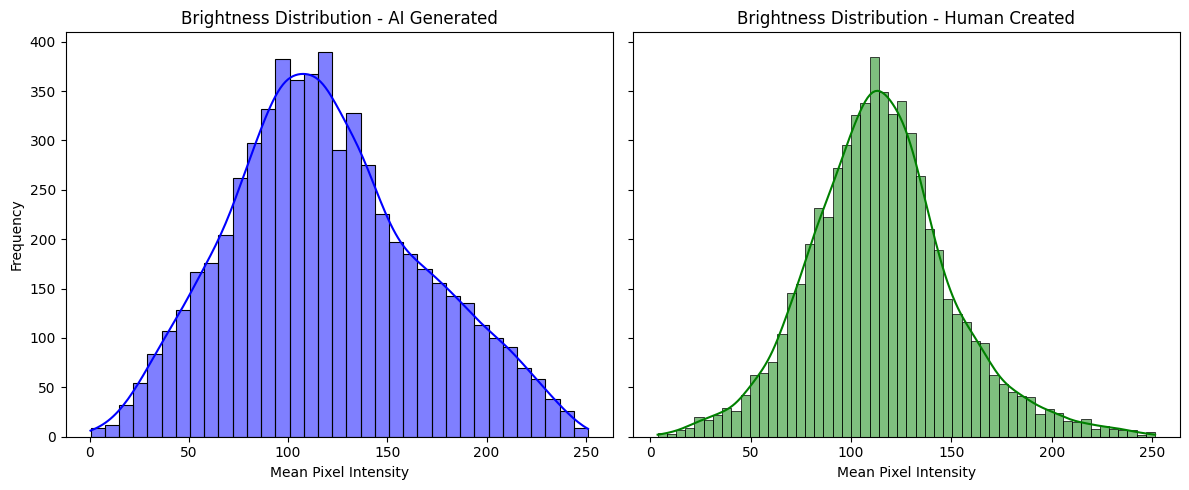

In [44]:
brightness_ai = [img.mean() for img in train_class0_array]
brightness_human = [img.mean() for img in train_class1_array]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(brightness_ai, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Brightness Distribution - AI Generated')

sns.histplot(brightness_human, kde=True, ax=axes[1], color='green')
axes[1].set_title('Brightness Distribution - Human Created')

for ax in axes:
    ax.set_xlabel('Mean Pixel Intensity')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Contrast/Standard Deviation**

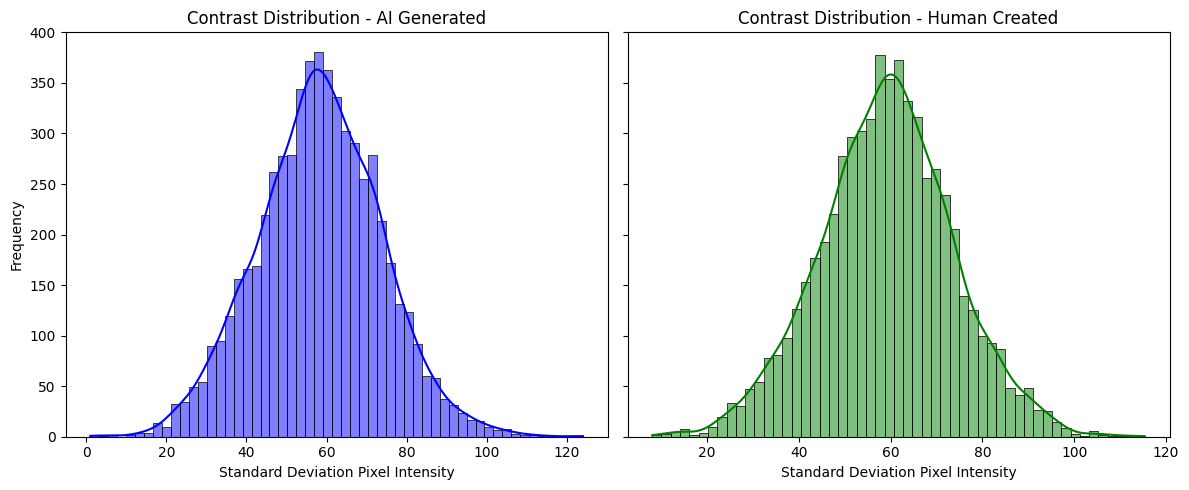

In [45]:
contrast_ai = [img.std() for img in train_class0_array]
contrast_human = [img.std() for img in train_class1_array]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(contrast_ai, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Contrast Distribution - AI Generated')

sns.histplot(contrast_human, kde=True, ax=axes[1], color='green')
axes[1].set_title('Contrast Distribution - Human Created')

for ax in axes:
    ax.set_xlabel('Standard Deviation Pixel Intensity')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Modeling Methods, Validation, and Performance Metrics:

## Setup modeling parameters

In [46]:
# User functions
confidence = 0.95
def conf_interval(scores):
  mean_score = np.mean(scores)

  confidence = 0.95
  n = len(scores)
  standard_error = st.sem(scores)
  h = standard_error * st.t.ppf((1 + confidence) / 2., n-1)

  ci_lower = mean_score - h
  ci_upper = mean_score + h
  return ci_lower, ci_upper

In [47]:
cols_to_drop = ['index', 'original_dataset', 'image_path', 'b_sum', 'g_sum', 'r_sum', 'r_mean', 'g_mean', 'b_median', 'g_std', 'gray_mean', 'edge_mean', 'edge_density']

train = train_meta.drop(columns=cols_to_drop)
val = val_meta.drop(columns=cols_to_drop, errors='ignore')
test = test_meta.drop(columns=cols_to_drop, errors='ignore')

X_train = train.drop(columns=['label'])
y_train = train['label']
X_val = val.drop(columns=['label'])
y_val = val['label']
X_test = test.drop(columns=['label'])
y_test = test['label']

## Baseline Models

### Logistic Regression

**Fit Model**

In [49]:
log_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(
        penalty='l2',
        max_iter=1000,
        random_state=42,
        n_jobs=-1
        )
)
log_scores = cross_val_score(log_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(f"Accuracy:{log_scores.mean():.4f}")

Accuracy:0.8070


**Confidence Intervals**

In [50]:
ci_lower, ci_upper = conf_interval(log_scores)

print(f"Mean score: {log_scores.mean():.4f}")
print(f"{confidence*100:.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean score: 0.8070
95% CI: (0.7992, 0.8148)


**Classification Report**

In [51]:
y_pred = cross_val_predict(log_model, X_train, y_train, cv=10, n_jobs=-1)
cm_val = classification_report(y_train, y_pred, digits=4, target_names=['AI', 'Human'])
print(cm_val)

              precision    recall  f1-score   support

          AI     0.8285    0.7721    0.7993      5973
       Human     0.7884    0.8415    0.8141      6025

    accuracy                         0.8070     11998
   macro avg     0.8084    0.8068    0.8067     11998
weighted avg     0.8083    0.8070    0.8067     11998



**Plot ROC**

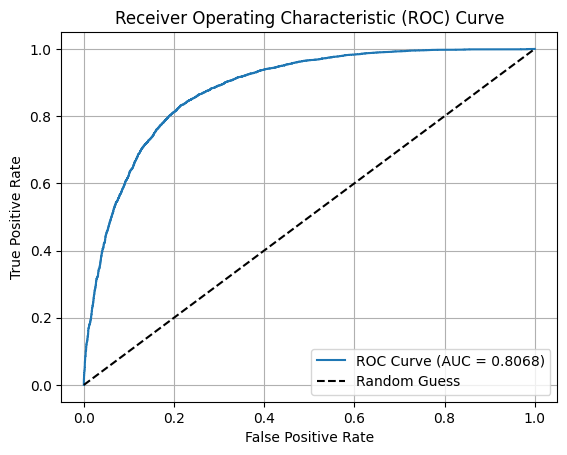

In [52]:
y_pred_proba = cross_val_predict(log_model, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
auc_log = roc_auc_score(y_train, y_pred)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_log:.4f})")
plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### SVM

**Make pipeline and use cross_val_score**

In [53]:
svm_pipeline = make_pipeline(
    (SimpleImputer(strategy='mean')),
    (StandardScaler()),
    (LinearSVC(random_state=42))
)

svm_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

**Confidence intervals**

In [54]:
ci_lower, ci_upper = conf_interval(svm_scores)

print(f"Mean Accuracy: {svm_scores.mean():.4f}")
print(f"{confidence*100:.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean Accuracy: 0.7909
95% CI: (0.7851, 0.7967)


**Classification report**

In [55]:
y_pred = cross_val_predict(svm_pipeline, X_train, y_train, cv=10, n_jobs=-1)
print(classification_report(y_train, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8178    0.7462    0.7804      5973
           1     0.7685    0.8352    0.8004      6025

    accuracy                         0.7909     11998
   macro avg     0.7931    0.7907    0.7904     11998
weighted avg     0.7930    0.7909    0.7904     11998



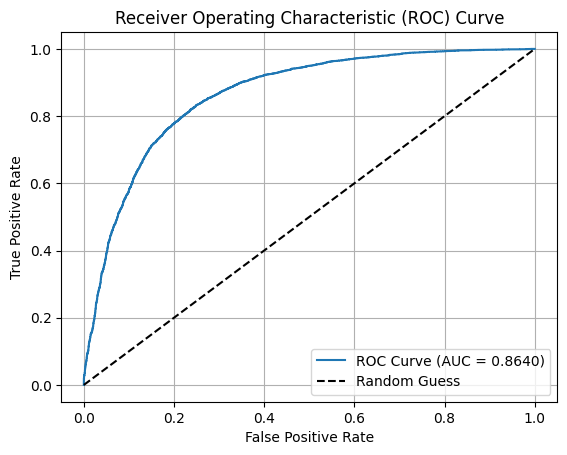

In [56]:
y_scores = cross_val_predict(svm_pipeline, X_train, y_train, cv=10, n_jobs=-1, method='decision_function')
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
auc_log = roc_auc_score(y_train, y_scores)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_log:.4f})")
plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Random Forest

**Use cross_val_score**

In [58]:
rf_clf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf_clf, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

**Confidence interval and accuracy**

In [59]:
ci_lower, ci_upper = conf_interval(rf_scores)

print(f"Mean Accuracy: {rf_scores.mean():.4f}")
print(f"{confidence*100:.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean Accuracy: 0.9205
95% CI: (0.9159, 0.9251)


**Classification report and ROC curve**


Classification Report (RF):
              precision    recall  f1-score   support

           0     0.9213    0.9188    0.9200      5973
           1     0.9197    0.9222    0.9209      6025

    accuracy                         0.9205     11998
   macro avg     0.9205    0.9205    0.9205     11998
weighted avg     0.9205    0.9205    0.9205     11998

AUC Score (RF): 0.9800


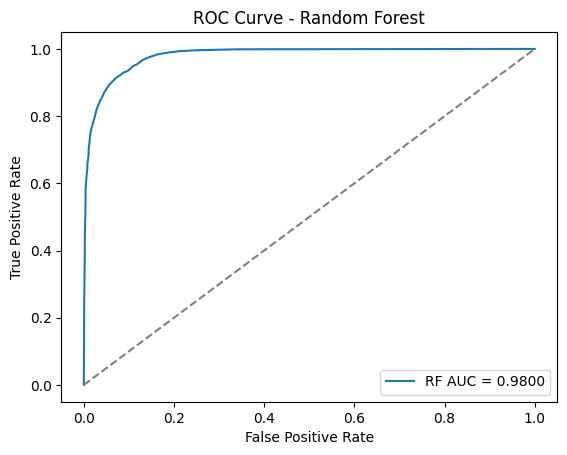

In [60]:
y_pred_rf = cross_val_predict(rf_clf, X_train, y_train, cv=10, n_jobs=-1)
y_prob_rf = cross_val_predict(rf_clf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]

print("\nClassification Report (RF):")
print(classification_report(y_train, y_pred_rf, digits=4))
print(f"AUC Score (RF): {roc_auc_score(y_train, y_prob_rf):.4f}")

#plot roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RF AUC = {roc_auc_score(y_train, y_prob_rf):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

## Feature Extraction from CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

In [64]:
# Load without top (classification) layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [65]:
# Stack arrays
X_train = np.array(train_arrays)
y_train = train_meta['label'].to_numpy()
X_val = np.array(val_arrays)
y_val = val_meta['label'].to_numpy()

**Method to extract features in batches**

In [66]:
# Read in batches as to not crash Google Colab

def feature_extract(batch, batch_size):
  features = []

  for i in range(0, len(batch), batch_size):
    new_batch = batch[i:i + batch_size]
    batch_features = base_model(new_batch)
    features.append(batch_features.numpy())
    del new_batch, batch_features

  return np.concatenate(features, axis=0)

**Run method and combine features**

In [67]:
train_features = feature_extract(X_train, 128)
val_features = feature_extract(X_val, 128)

In [68]:
# Save features then read them back in if switching back to CPU from GPU in Colab
train_df = pd.DataFrame(train_features)
train_df['label'] = y_train
val_df = pd.DataFrame(val_features)
val_df['label'] = y_val
train_df.to_parquet(FEATURES_DIR / "train_features_final.parquet")
val_df.to_parquet(FEATURES_DIR / "val_features_final.parquet")

**Read features back in**

In [69]:
train_features = pd.read_parquet(FEATURES_DIR / "train_features_final.parquet")
val_features = pd.read_parquet(FEATURES_DIR / "val_features_final.parquet")
X_train = train_features.drop(columns=['label'])
y_train = train_features['label']
X_val = val_features.drop(columns=['label'])
y_val = val_features['label']

**Set up models and get scores**

In [70]:
svm_cnn_model = LinearSVC(random_state=42)
rf_cnn_model = RandomForestClassifier(random_state=42, n_jobs=-1)
lr_cnn_model = LogisticRegression(random_state=42, n_jobs=-1)

svm_cnn_scores = cross_val_score(svm_cnn_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
rf_cnn_scores = cross_val_score(rf_cnn_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
lr_cnn_scores = cross_val_score(lr_cnn_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

**Confidence intervals and accuracy**

In [71]:
svm_ci_lower, svm_ci_upper = conf_interval(svm_cnn_scores)
rf_ci_lower, rf_ci_upper = conf_interval(rf_cnn_scores)
lr_ci_lower, lr_ci_upper = conf_interval(lr_cnn_scores)

print(f"SVM Accuracy: {svm_cnn_scores.mean():.4f}")
print(f"SVM {confidence*100:.0f}% CI: ({svm_ci_lower:.4f}, {svm_ci_upper:.4f})")
print(f"\nRandom Forest Accuracy: {rf_cnn_scores.mean():.4f}")
print(f"Random Forest {confidence*100:.0f}% CI: ({rf_ci_lower:.4f}, {rf_ci_upper:.4f})")
print(f"\nLog Reg Accuracy: {lr_cnn_scores.mean():.4f}")
print(f"Log Reg {confidence*100:.0f}% CI: ({lr_ci_lower:.4f}, {lr_ci_upper:.4f})")

SVM Accuracy: 0.7835
SVM 95% CI: (0.7751, 0.7918)

Random Forest Accuracy: 0.7685
Random Forest 95% CI: (0.7596, 0.7775)

Log Reg Accuracy: 0.7810
Log Reg 95% CI: (0.7720, 0.7900)


**Classification Report**

In [72]:
svm_preds = cross_val_predict(svm_cnn_model, X_train, y_train, cv=5, n_jobs=-1)
rf_preds = cross_val_predict(rf_cnn_model, X_train, y_train, cv=5, n_jobs=-1)
lr_preds = cross_val_predict(lr_cnn_model, X_train, y_train, cv=5, n_jobs=-1)

print("SVM MODEL RESULTS")
print(classification_report(y_train, svm_preds, digits=4))
print("\nRANDOM FOREST RESULTS")
print(classification_report(y_train, rf_preds, digits=4))
print("\nLOGISTIC REGRESSION RESULTS")
print(classification_report(y_train, lr_preds, digits=4))

SVM MODEL RESULTS
              precision    recall  f1-score   support

           0     0.7816    0.7773    0.7795      5973
           1     0.7805    0.7847    0.7826      6025

    accuracy                         0.7810     11998
   macro avg     0.7811    0.7810    0.7810     11998
weighted avg     0.7811    0.7810    0.7810     11998


RANDOM FOREST RESULTS
              precision    recall  f1-score   support

           0     0.7508    0.7901    0.7699      5973
           1     0.7805    0.7401    0.7598      6025

    accuracy                         0.7650     11998
   macro avg     0.7657    0.7651    0.7649     11998
weighted avg     0.7657    0.7650    0.7648     11998


LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

           0     0.7831    0.7783    0.7807      5973
           1     0.7816    0.7862    0.7839      6025

    accuracy                         0.7823     11998
   macro avg     0.7823    0.7823    0.7823     11998
weig

### Hyperparameter Tuning

#### SVM Model

In [75]:
tuned_svm_model = make_pipeline(
    (StandardScaler()),
    (LinearSVC(random_state=42, loss='squared_hinge', penalty='l1', dual=False))
)

param_grid = [
    {
    'linearsvc__C': [0.01, .009, .008],
    'linearsvc__max_iter': [300, 400, 500]
    }
]

svm_grid = HalvingGridSearchCV(tuned_svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=10, random_state=42)
svm_grid.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1333
max_resources_: 11998
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1333
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 3999
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 11997
Fitting 5 folds for each of 1 candidates, totalling 5 fits


HalvingGridSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('linearsvc',
                                               LinearSVC(dual=False,
                                                         penalty='l1',
                                                         random_state=42))]),
                    n_jobs=-1,
                    param_grid=[{'linearsvc__C': [0.01, 0.009, 0.008],
                                 'linearsvc__max_iter': [300, 400, 500]}],
                    random_state=42, scoring='accuracy', verbose=10)

In [76]:
print(svm_grid.best_params_)
print(svm_grid.best_score_)

{'linearsvc__C': 0.008, 'linearsvc__max_iter': 500}
0.7983829097542381


**Cross val score with best model**

In [77]:
best_svm = svm_grid.best_estimator_

best_svm_scores = cross_val_score(best_svm, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

**Confidence intervals and accuracy**

In [78]:
ci_lower, ci_upper = conf_interval(best_svm_scores)

print(f"Mean Accuracy: {best_svm_scores.mean():.4f}")
print(f"{confidence*100:.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean Accuracy: 0.8006
95% CI: (0.7934, 0.8077)


#### Random Forest

In [79]:
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV

tuned_rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [300, 400, 500],
    'min_samples_split': [2, 3, 4],
    "max_depth": [20, 24, 30],
    "min_samples_leaf": [2, 3, 4, 6],
    'max_features': [.2, .3, .4]
}

rf_grid = HalvingGridSearchCV(tuned_rf_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=10, factor=4, random_state=42)
rf_grid.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 46
max_resources_: 11998
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 324
n_resources: 46
Fitting 3 folds for each of 324 candidates, totalling 972 fits
----------
iter: 1
n_candidates: 81
n_resources: 184
Fitting 3 folds for each of 81 candidates, totalling 243 fits
----------
iter: 2
n_candidates: 21
n_resources: 736
Fitting 3 folds for each of 21 candidates, totalling 63 fits
----------
iter: 3
n_candidates: 6
n_resources: 2944
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 4
n_candidates: 2
n_resources: 11776
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=3,
                    estimator=RandomForestClassifier(n_jobs=-1,
                                                     random_state=42),
                    factor=4, n_jobs=-1,
                    param_grid={'max_depth': [20, 24, 30],
                                'max_features': [0.2, 0.3, 0.4],
                                'min_samples_leaf': [2, 3, 4, 6],
                                'min_samples_split': [2, 3, 4],
                                'n_estimators': [300, 400, 500]},
                    random_state=42, scoring='accuracy', verbose=10)

In [80]:
best_rf = rf_grid.best_estimator_
print(best_rf.get_params())
print(best_rf.score(X_val, y_val))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 0.4, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.781854569713142


**Cross val score on best model**

In [81]:
best_rf_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

**Confidence intervals and accuracy**

In [82]:
ci_lower, ci_upper = conf_interval(best_rf_scores)

print(f"Mean Accuracy: {best_rf_scores.mean():.4f}")
print(f"{confidence*100:.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean Accuracy: 0.7750
95% CI: (0.7683, 0.7817)


#### Logistic Regression

In [83]:
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV

tuned_lr_model = make_pipeline(
    (StandardScaler()),
    (LogisticRegression(random_state=42, solver='liblinear', penalty='l1'))
)

param_grid = [
    {
        "logisticregression__C": [0.1, .05, .04],
        "logisticregression__max_iter": [500, 750, 1000]
    }
]


lr_grid = HalvingGridSearchCV(tuned_lr_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=10, random_state=42)
lr_grid.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1333
max_resources_: 11998
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1333
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 3999
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 11997
Fitting 5 folds for each of 1 candidates, totalling 5 fits


HalvingGridSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear'))]),
                    n_jobs=-1,
                    param_grid=[{'logisticregression__C': [0.1, 0.05, 0.04],
                                 'logisticregression__max_iter': [500, 750,
                                                                  1000]}],
                    random_state=42, scoring='accuracy', verbose=10)

In [84]:
best_lr = lr_grid.best_estimator_
print(best_lr.get_params())
print(best_lr.score(X_val, y_val))

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression(C=0.05, max_iter=750, penalty='l1', random_state=42,
                   solver='liblinear'))], 'transform_input': None, 'verbose': False, 'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(C=0.05, max_iter=750, penalty='l1', random_state=42,
                   solver='liblinear'), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'logisticregression__C': 0.05, 'logisticregression__class_weight': None, 'logisticregression__dual': False, 'logisticregression__fit_intercept': True, 'logisticregression__intercept_scaling': 1, 'logisticregression__l1_ratio': None, 'logisticregression__max_iter': 750, 'logisticregression__multi_class': 'deprecated', 'logisticregression__n_jobs': None, 'logisticregression__penalty': 'l1', 'logisticregression__random_state': 42, 'logisticregression__solver': 'liblinear', 'logisticre

**Cross val score on best model**

In [85]:
best_lr_scores = cross_val_score(best_lr, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

**Confidence intervals and accuracy**

In [86]:
ci_lower, ci_upper = conf_interval(best_lr_scores)

print(f"Mean Accuracy: {best_lr_scores.mean():.4f}")
print(f"{confidence*100:.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean Accuracy: 0.8002
95% CI: (0.7901, 0.8104)


#### Comparison

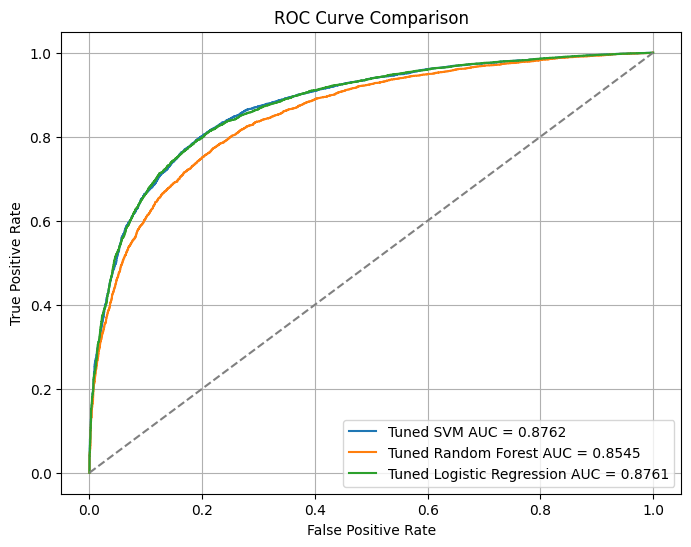

In [87]:
#ROC for SVM
y_score = cross_val_predict(best_svm, X_train, y_train, cv=10, n_jobs=-1, method='decision_function')
fpr_svm, tpr_svm, _ = roc_curve(y_train, y_score)
auc_svm = roc_auc_score(y_train, y_score)

#ROC for Random Forest
y_prob_rf = cross_val_predict(best_rf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_prob_rf)
auc_rf = roc_auc_score(y_train, y_prob_rf)

#ROC for Log Reg
y_prob_lr = cross_val_predict(best_lr, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_train, y_prob_lr)
auc_lr = roc_auc_score(y_train, y_prob_lr)

#plot all three
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"Tuned SVM AUC = {auc_svm:.4f}")
plt.plot(fpr_rf, tpr_rf, label=f"Tuned Random Forest AUC = {auc_rf:.4f}")
plt.plot(fpr_lr, tpr_lr, label=f"Tuned Logistic Regression AUC = {auc_lr:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

## CNN Model Fine-Tuning

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

In [88]:
# import numpy as np
# import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

**Read in arrays if needed**

In [89]:
# Read arrays back
train_file_path = sorted(glob.glob(str(ARRAYS_DIR / "train" / "image_*.npy")))
val_file_path = sorted(glob.glob(str(ARRAYS_DIR / "validation" / "image_*.npy")))
test_file_path = sorted(glob.glob(str(ARRAYS_DIR / "test" / "image_*.npy")))

def load_npy(file_path):
  return np.load(file_path)

with ThreadPoolExecutor(max_workers=6) as executor:
  train_arrays = list(executor.map(load_npy, train_file_path))
  val_arrays = list(executor.map(load_npy, val_file_path))
  test_arrays = list(executor.map(load_npy, test_file_path))

X_train = np.array(train_arrays)
y_train = train_meta['label'].to_numpy()

X_val = np.array(val_arrays)
y_val = val_meta['label'].to_numpy()

X_test = np.array(test_arrays)
y_test = test_meta['label'].to_numpy()

**Train classification layer, then freeze layers and fine-tune model**

In [90]:
# Load base model with ImageNet weights
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# -------------------
# Stage 1: Train top only
# -------------------
base_model.trainable = False  # Freeze all layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.inputs, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Stage 1: Training top classifier only...")
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

# -------------------
# Stage 2: Fine-tune deeper layers
# -------------------
# Unfreeze last N layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False  # Keep early layers frozen

for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

# Re-compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Stage 2: Fine-tuning deeper layers...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Stage 1: Training top classifier only...
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 244s 628ms/step - accuracy: 0.6467 - loss: 0.6236 - val_accuracy: 0.7592 - val_loss: 0.5035
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 238s 635ms/step - accuracy: 0.7650 - loss: 0.5106 - val_accuracy: 0.7792 - val_loss: 0.4755
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 277s 738ms/step - accuracy: 0.7780 - loss: 0.4888 - val_accuracy: 0.7879 - val_loss: 0.4632
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 230s 613ms/step - accuracy: 0.7738 - loss: 0.4824 - val_accuracy: 0.7972 - val_loss: 0.4551
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 234s 625ms/step - accuracy: 0.7817 - loss: 0.4728 - val_accuracy: 0.7979 - val_loss: 0.4526
Stage 2: Fine-tuning deeper layers...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 339s 871ms/step - accuracy: 0.7920 - loss: 0.4556 - val_accuracy: 0.8132 - val_loss: 0.4259
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 287s 766ms/step - accuracy: 0.8150 - loss: 0.4162 - val_accuracy: 0.8272 - val_loss: 0.4059
Ep

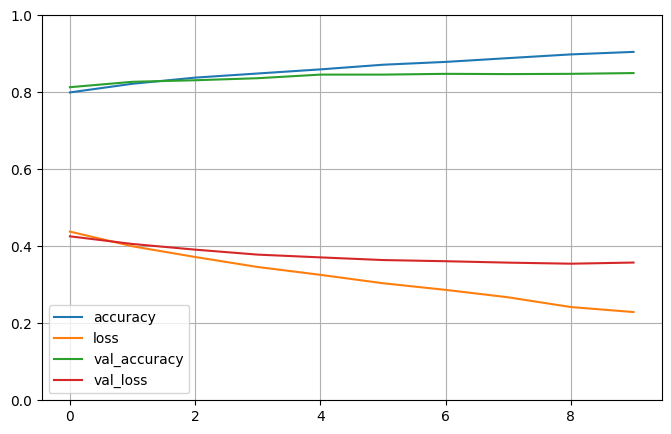

In [91]:
pd.DataFrame(history.history)[['accuracy', 'loss', 'val_accuracy', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [92]:
y_pred_proba = model.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype("int32")
print(classification_report(y_val, y_pred, target_names=["AI", "Human"]))

47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 616ms/step
              precision    recall  f1-score   support

          AI       0.83      0.89      0.86       755
       Human       0.88      0.81      0.84       744

    accuracy                           0.85      1499
   macro avg       0.85      0.85      0.85      1499
weighted avg       0.85      0.85      0.85      1499



In [93]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["AI", "Human"]))

47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 582ms/step
              precision    recall  f1-score   support

          AI       0.84      0.87      0.85       755
       Human       0.86      0.84      0.85       745

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



## CNN Model Hyper Parameter Tuning

In [94]:
!pip install -q keras_tuner
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

**Hyper Model Class with parameter to tune**

In [95]:
class EfficientNetHyperModel(kt.HyperModel):
  def __init__(self, input_shape, num_classes=1):
    self.input_shape = input_shape
    self.num_classes = num_classes

  def build(self, hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False

    input = tf.keras.Input(shape=self.input_shape, name="our_input_layer")
    augmentation_layer = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(
            mode=hp.Choice('flip_mode', ['horizontal', 'vertical', 'horizontal_and_vertical'])
            ),
        tf.keras.layers.RandomRotation(
            factor=hp.Float("rotation_factor", min_value=0, max_value=.3, step=.1),
            fill_mode=hp.Choice("fill_mode", ['constant', 'reflect', 'wrap', 'nearest']),
            interpolation=hp.Choice("interpolation", ['nearest', 'bilinear'])
            ),
        tf.keras.layers.RandomContrast(
            factor=hp.Float("contrast_factor", min_value=0, max_value=1, step=.2)
        )
    ], name='augmentation_layer')

    x = augmentation_layer(input)
    x = base_model(x, training=False)

    pooling = hp.Choice("pooling", ["avg", "max"])
    if pooling == "avg":
      x = tf.keras.layers.GlobalAveragePooling2D()(x)
    else:
      x = tf.keras.layers.GlobalMaxPooling2D()(x)


    if hp.Boolean("add_dense"):
      x = tf.keras.layers.Dense(
          units=hp.Int("dense_units", min_value=64, max_value=256, step=64),
          activation='relu', name = "our_dense_layer"
      )(x)

    x = tf.keras.layers.Dropout(rate=hp.Float('head_dropout', min_value=0, max_value=.5, step=.1), name="Dropout")(x)

    output = tf.keras.layers.Dense(units=self.num_classes, activation='sigmoid', name="output_layer")(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop", "adamw"])

    if optimizer_choice == "adam":
      from tensorflow.keras.optimizers import Adam
      optimizer = Adam(learning_rate=lr)
    elif optimizer_choice == "rmsprop":
      from tensorflow.keras.optimizers import RMSprop
      optimizer = RMSprop(learning_rate=lr)
    else:
      from tensorflow.keras.optimizers import AdamW
      optimizer = AdamW(learning_rate=lr, weight_decay=hp.Float('adamw_weight_decay', min_value=1e-7, max_value=.01, sampling='log'))

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
                           tf.keras.metrics.AUC(name='AUC')]
                  )

    return model

**Set up tuner**

In [96]:
tuner = kt.Hyperband(
    hypermodel=EfficientNetHyperModel(input_shape=(224, 224, 3)),
    objective='val_accuracy',
    seed=10,
    max_epochs=20,
    hyperband_iterations=2,
    executions_per_trial=2,
    directory=str(EXPERIMENTS_DIR),
    project_name='full_hyperparm_tuning'
)

Reloading Tuner from /content/drive/MyDrive/MSADS 504 Final Project Folder/data/full_hyperparm_tuning/tuner0.json


In [97]:
# Once done, the tuner object can be called again to load completed trials
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'flip_mode': 'horizontal', 'rotation_factor': 0.1, 'fill_mode': 'wrap', 'interpolation': 'bilinear', 'contrast_factor': 0.6000000000000001, 'pooling': 'avg', 'add_dense': True, 'head_dropout': 0.30000000000000004, 'learning_rate': 0.000503669167561544, 'optimizer': 'rmsprop', 'dense_units': 192, 'adamw_weight_decay': 3.13029911467793e-05, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0035'}


**Search through hp space to find best parameters**

In [98]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping]
)

**Use best hp's to rebuild model**

In [99]:
best_hp = tuner.get_best_hyperparameters()[0]
my_model = EfficientNetHyperModel(input_shape=(224, 224, 3))
best_model = my_model.build(best_hp)
best_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ our_input_layer (InputLayer)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layer (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ our_dense_layer (Dense)         │ (None, 192)            │       245,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,295,716 (16.39 MB)

 Trainable params: 246,145 (961.50 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [100]:
best_model = tf.keras.models.load_model(MODELS_DIR / "efficient_net_top_model.keras")

In [101]:
best_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ our_input_layer (InputLayer)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layer (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ our_dense_layer (Dense)         │ (None, 192)            │       245,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,541,863 (17.33 MB)

 Trainable params: 246,145 (961.50 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 246,147 (961.52 KB)

**Un-freeze layers**

In [102]:
base_model = best_model.get_layer('efficientnetb0')

base_model.trainable = True

for layer in base_model.layers[:-50]:
  layer.trainable = False

**Fit model for fine-tuning with early stoppage**

In [103]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

best_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 335s 855ms/step - accuracy: 0.5620 - loss: 0.6798 - val_accuracy: 0.6871 - val_loss: 0.6011
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 340s 908ms/step - accuracy: 0.6953 - loss: 0.5908 - val_accuracy: 0.7505 - val_loss: 0.5421
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 312s 831ms/step - accuracy: 0.7505 - loss: 0.5350 - val_accuracy: 0.7732 - val_loss: 0.5033
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 332s 886ms/step - accuracy: 0.7625 - loss: 0.4990 - val_accuracy: 0.7825 - val_loss: 0.4779
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 287s 764ms/step - accuracy: 0.7832 - loss: 0.4700 - val_accuracy: 0.7945 - val_loss: 0.4604
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 339s 903ms/step - accuracy: 0.7976 - loss: 0.4478 - val_accuracy: 0.7965 - val_loss: 0.4489
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 281s 750ms/step - accuracy: 0.8040 - loss: 0.4329 - val_accuracy: 0.7952 - val_loss: 0.4383
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 308s 821ms/step - accuracy: 0.8070 -

**Plot loss curve and evaluate on test data**

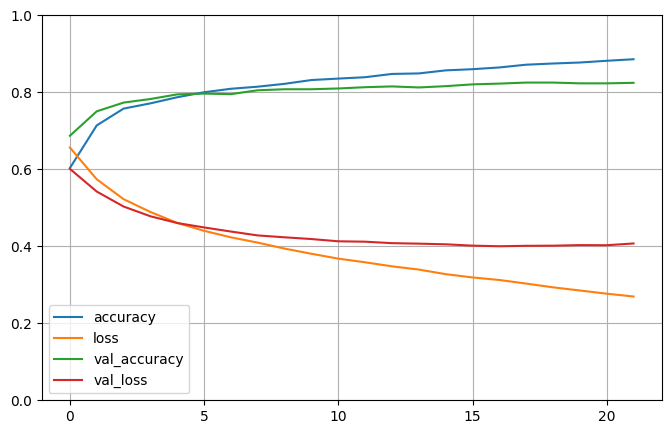

In [104]:
pd.DataFrame(history.history)[['accuracy', 'loss', 'val_accuracy', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [105]:
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["Human", "AI"]))

47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 619ms/step
              precision    recall  f1-score   support

       Human       0.84      0.81      0.82       755
          AI       0.81      0.84      0.83       745

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.83      0.82      0.82      1500



## Final Tuning of Best Model

In [106]:
# Reset data if need be
cols_to_drop = ['index', 'original_dataset', 'image_path', 'b_sum', 'g_sum', 'r_sum', 'r_mean', 'g_mean', 'b_median', 'g_std', 'gray_mean', 'edge_mean', 'edge_density']

train = train_meta.drop(columns=cols_to_drop)
val = val_meta.drop(columns=cols_to_drop, errors='ignore')
test = test_meta.drop(columns=cols_to_drop, errors='ignore')

X_train = train.drop(columns=['label'])
y_train = train['label']
X_val = val.drop(columns=['label'])
y_val = val['label']
X_test = test.drop(columns=['label'])
y_test = test['label']

**Hyperparameter tuning**

In [107]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

best_model = RandomForestClassifier(random_state=42, n_estimators=300, n_jobs=-1)

param_grid = {
    "max_depth": [12, 13],
    "min_samples_leaf": [1, 2, 3],
    'max_features': [.5, .6]
}

best_grid = HalvingGridSearchCV(best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=10, factor=3, random_state=42)
best_grid.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1333
max_resources_: 11998
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 1333
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 3999
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 11997
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=42),
                    n_jobs=-1,
                    param_grid={'max_depth': [12, 13],
                                'max_features': [0.5, 0.6],
                                'min_samples_leaf': [1, 2, 3]},
                    random_state=42, scoring='accuracy', verbose=10)

In [108]:
best_model = best_grid.best_estimator_
print(best_model.get_params())
print(best_model.score(X_val, y_val))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.923949299533022


**Combine validation and train data**

In [109]:
new_X = pd.concat([X_train, X_val])
new_y = pd.concat([y_train, y_val])

**Compare learning curves to check for overfitting**

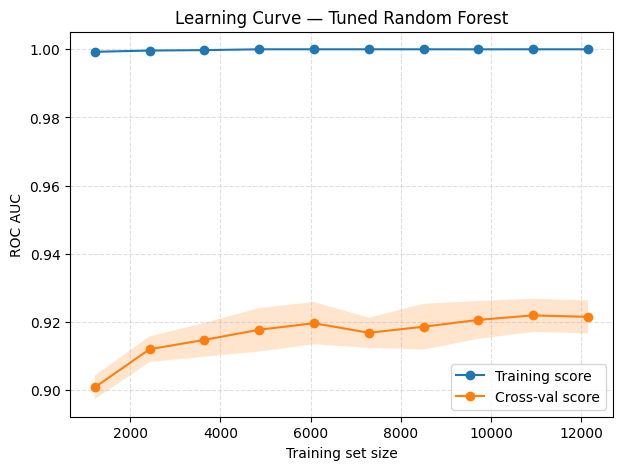

Final CV AUC at full size: 0.921538588254674


In [110]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=rf_clf,
    X=new_X,
    y=new_y,
    train_sizes=train_sizes,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std  = valid_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker='o', label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)

plt.plot(train_sizes, valid_mean, marker='o', label='Cross-val score')
plt.fill_between(train_sizes, valid_mean-valid_std, valid_mean+valid_std, alpha=0.2)

plt.xlabel('Training set size')
plt.ylabel('ROC AUC')
plt.title('Learning Curve — Tuned Random Forest')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print("Final CV AUC at full size:", valid_mean[-1])


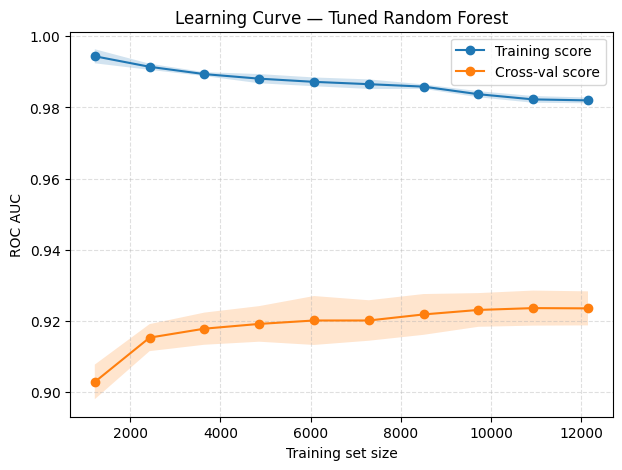

Final CV AUC at full size: 0.923538643165033


In [111]:
from sklearn.model_selection import learning_curve
from sklearn.base import clone

best_model_clone = clone(best_model)

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_model_clone,
    X=new_X,
    y=new_y,
    train_sizes=train_sizes,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std  = valid_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker='o', label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)

plt.plot(train_sizes, valid_mean, marker='o', label='Cross-val score')
plt.fill_between(train_sizes, valid_mean-valid_std, valid_mean+valid_std, alpha=0.2)

plt.xlabel('Training set size')
plt.ylabel('ROC AUC')
plt.title('Learning Curve — Tuned Random Forest')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print("Final CV AUC at full size:", valid_mean[-1])

**Calculate scores and confidence intervals**

In [112]:
best_model_clone = clone(best_model)

rf_scores = cross_val_score(best_model_clone, new_X, new_y, cv=10, scoring='accuracy', n_jobs=-1)
ci_lower, ci_upper = conf_interval(rf_scores)

print(f"Mean Accuracy: {rf_scores.mean():.4f}")
print(f"{confidence*100:.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean Accuracy: 0.9236
95% CI: (0.9200, 0.9272)


**Final model evaluation**


Classification Report (RF):
              precision    recall  f1-score   support

          AI     0.9180    0.9046    0.9113       755
       Human     0.9048    0.9181    0.9114       745

    accuracy                         0.9113      1500
   macro avg     0.9114    0.9114    0.9113      1500
weighted avg     0.9114    0.9113    0.9113      1500

AUC Score (RF): 0.9727


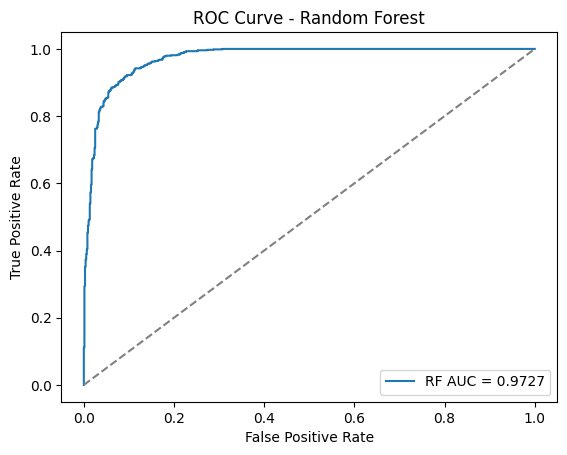

In [113]:
final_model = best_model_clone
final_model.fit(new_X, new_y)

y_pred_rf = cross_val_predict(final_model, X_test, y_test, cv=10, n_jobs=-1)
y_prob_rf = cross_val_predict(final_model, X_test, y_test, cv=10, n_jobs=-1, method='predict_proba')[:, 1]

print("\nClassification Report (RF):")
print(classification_report(y_test, y_pred_rf, digits=4, target_names=['AI', 'Human']))
print(f"AUC Score (RF): {roc_auc_score(y_test, y_prob_rf):.4f}")

#plot roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RF AUC = {roc_auc_score(y_test, y_prob_rf):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()